<a href="https://colab.research.google.com/github/ShuHuiK/WIE3007_Group_Assignment/blob/ShuHui/Neural_Network_Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score, roc_curve

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. LOAD DATA
df = pd.read_csv('2025_Sterling_Financial_Dataset_clean.csv')

In [2]:
# 2. PREPROCESSING
# Dropping non-predictive columns
drop_cols = ['date', 'customer_id', 'customer_feedback', 'location']
X = df.drop(columns=['default_history'] + drop_cols)
y = df['default_history']

# Defining numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Creating the transformer pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Fit and transform
X_processed = preprocessor.fit_transform(X)

In [3]:
# 3. SPLIT DATA
# Stratify ensures the minority class is represented in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y.values, test_size=0.2, random_state=42, stratify=y
)

In [4]:
# 4. HANDLE CLASS IMBALANCE
# Calculating weights to make the model "pay more attention" to the minority class (Default)
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weights[i] for i in range(len(weights))}

In [5]:
# 5. BUILD NEURAL NETWORK
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3), # Prevents overfitting
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') # Sigmoid for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# 6. TRAIN MODEL
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=0
)

In [7]:
# 7. EVALUATION MODULE
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n" + "="*30)
print("MODULE EVALUATION METRICS")
print("="*30)
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

# Specific metric prints
auc_val = roc_auc_score(y_test, y_pred_prob)
f1_val = f1_score(y_test, y_pred)
print(f"ROC AUC Score: {auc_val:.4f}")
print(f"F1 Score:      {f1_val:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

MODULE EVALUATION METRICS
              precision    recall  f1-score   support

  No Default       0.97      0.92      0.94       282
     Default       0.28      0.50      0.36        18

    accuracy                           0.89       300
   macro avg       0.62      0.71      0.65       300
weighted avg       0.93      0.89      0.91       300

ROC AUC Score: 0.7914
F1 Score:      0.3600


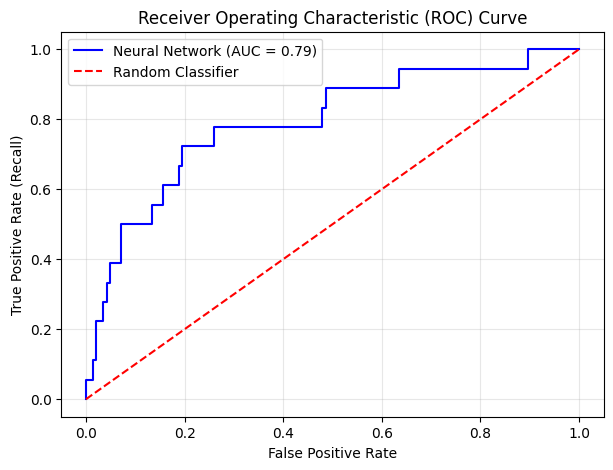

In [8]:
# 8. ROC CURVE VISUALIZATION
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', label=f'Neural Network (AUC = {auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.show()